In [2]:
import os
import pandas as pd

# Path to your image dataset
dataset_dir = r"C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Obliteration\ML\Poke_images\Dataset_types"

# List to store image paths and labels
data = []

# Walk through each folder (type)
for label in os.listdir(dataset_dir):
    label_path = os.path.join(dataset_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                full_path = os.path.join(label_path, file)
                data.append({'image_path': full_path, 'label': label})

# Create DataFrame
df = pd.DataFrame(data)

# Preview
print(df.head())


                                          image_path label
0  C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Oblit...   Bug
1  C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Oblit...   Bug
2  C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Oblit...   Bug
3  C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Oblit...   Bug
4  C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Oblit...   Bug


In [3]:
import os
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToPILImage
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm
warnings.filterwarnings("ignore", category=FutureWarning)
root_dir = os.getcwd()

def fisher_score(X, y):
    classes = np.unique(y)
    overall_mean = np.mean(X, axis=0)
    num, denom = 0, 0
    for cls in classes:
        cls_samples = X[y == cls]
        cls_mean = np.mean(cls_samples, axis=0)
        num += len(cls_samples) * np.sum((cls_mean - overall_mean)**2)
        denom += np.sum((cls_samples - cls_mean)**2)
    return num / denom if denom != 0 else 0


In [4]:
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (val + test)
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)

# Second split: ⅔ val (20%), ⅓ test (10%) from temp
val_df, test_df = train_test_split(
    temp_df, test_size=1/3, stratify=temp_df['label'], random_state=42
)

# Optional: Save splits to CSV like Minecraft project
train_df.to_csv("train_set.csv", index=False)
val_df.to_csv("val_set.csv", index=False)
test_df.to_csv("test_set.csv", index=False)

# Summary
dataset_size = len(df)
print("After splitting Pokémon image dataset:")
print(f"Total dataset size: {dataset_size}")
print(f"Training set size: {len(train_df)} ({len(train_df)/dataset_size*100:.2f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/dataset_size*100:.2f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/dataset_size*100:.2f}%)")


After splitting Pokémon image dataset:
Total dataset size: 22253
Training set size: 15577 (70.00%)
Validation set size: 4450 (20.00%)
Test set size: 2226 (10.00%)


In [5]:
# Map each label (Pokémon type) to an index
label_mapping = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}

class PokemonDataset(Dataset):
    def __init__(self, df, transform=None):
        self.img_paths = df['image_path'].tolist()
        self.labels = df['label'].map(label_mapping).tolist()
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, torch.tensor(label, dtype=torch.int64)


In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


In [8]:
train_set = PokemonDataset(train_df, transform)
val_set = PokemonDataset(val_df, transform)
test_set = PokemonDataset(test_df, transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [9]:
use_colors = {
    'Fire': 'red',
    'Water': 'blue',
    'Grass': 'green',
    'Electric': 'yellow',
    'Psychic': 'purple',
    'Fighting': 'brown',
    'Poison': 'violet',
    'Ground_Rock': 'saddlebrown',
    'Bug': 'lime',
    'Normal': 'lightgray',
}


In [10]:
def extract_features_and_labels(loader):
    features = []
    labels = []
    for imgs, lbls in tqdm(loader, desc="Extracting features"):
        imgs = imgs.view(imgs.size(0), -1)  # Flatten from [B, C, H, W] → [B, C*H*W]
        features.append(imgs.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)


In [11]:
# Extract flattened [0,1] features from normalized tensors
X_train, y_train = extract_features_and_labels(train_loader)
X_test, y_test = extract_features_and_labels(test_loader)


Extracting features:   0%|          | 0/244 [00:00<?, ?it/s]c:\Users\Ntinos\anaconda3\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Extracting features: 100%|██████████| 35/35 [00:15<00:00,  2.31it/s]


In [12]:
from sklearn.decomposition import PCA

# Reduce to 3000 PCA components
pca = PCA(n_components=3000)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA to reduce to n_classes - 1 dimensions (auto)
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_pca, y_train)
X_test_lda = lda.transform(X_test_pca)


LinAlgError: SVD did not converge

In [13]:
from sklearn.metrics import accuracy_score

y_pred = lda.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

print("LDA Classifier Accuracy:", accuracy)
print("Original features:", X_train.shape[1])
print("After PCA:", X_train_pca.shape[1])
print("After LDA:", X_train_lda.shape[1])


LDA Classifier Accuracy: 0.4146451033243486
Original features: 12288
After PCA: 3000
After LDA: 9


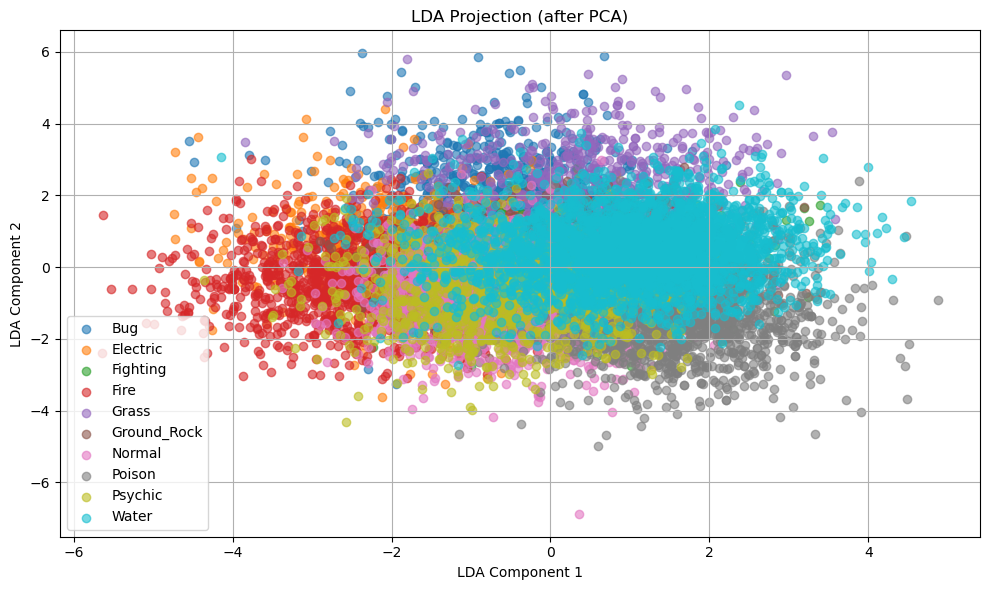

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(X_train_lda[idx, 0], X_train_lda[idx, 1],
                label=list(label_mapping.keys())[list(label_mapping.values()).index(label)],
                alpha=0.6)

plt.title("LDA Projection (after PCA)")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


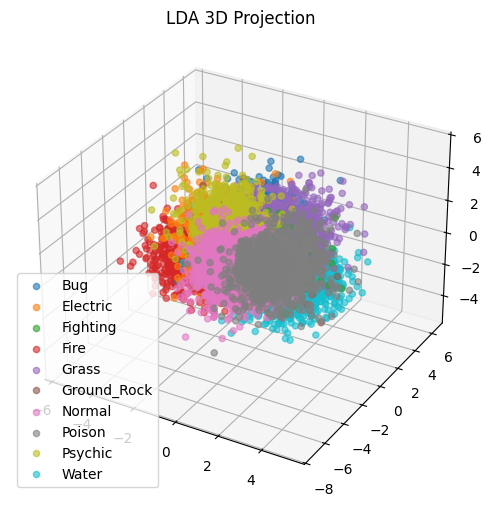

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D plot with first 3 LDA components
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for label in np.unique(y_train):
    idx = y_train == label
    ax.scatter(X_train_lda[idx, 0], X_train_lda[idx, 1], X_train_lda[idx, 2],
               label=list(label_mapping.keys())[list(label_mapping.values()).index(label)],
               alpha=0.6)
ax.set_title('LDA 3D Projection')
ax.legend()
plt.show()


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

logreg = LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(logreg, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_lda, y_train)

print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 1, 'penalty': 'l2'}


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_lda)
y_proba = best_model.predict_proba(X_test_lda)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# ROC AUC for multiclass
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
roc_auc = roc_auc_score(y_test_bin, y_proba, average='weighted', multi_class='ovr')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Accuracy: 0.4097
Precision: 0.4017
Recall: 0.4097
F1 Score: 0.4011
ROC AUC: 0.7651


In [17]:
score = fisher_score(X_train_lda, y_train)
print("Fisher Score of LDA-transformed features:", score)


Fisher Score of LDA-transformed features: 0.51965183


In [18]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=list(label_mapping.keys()))
print(report)


              precision    recall  f1-score   support

         Bug       0.36      0.23      0.28       156
    Electric       0.35      0.29      0.32       155
    Fighting       0.21      0.13      0.16       109
        Fire       0.42      0.44      0.43       228
       Grass       0.49      0.40      0.44       123
 Ground_Rock       0.32      0.26      0.29       206
      Normal       0.41      0.51      0.46       368
      Poison       0.50      0.53      0.52       273
     Psychic       0.38      0.30      0.33       159
       Water       0.42      0.53      0.47       449

    accuracy                           0.41      2226
   macro avg       0.39      0.36      0.37      2226
weighted avg       0.40      0.41      0.40      2226



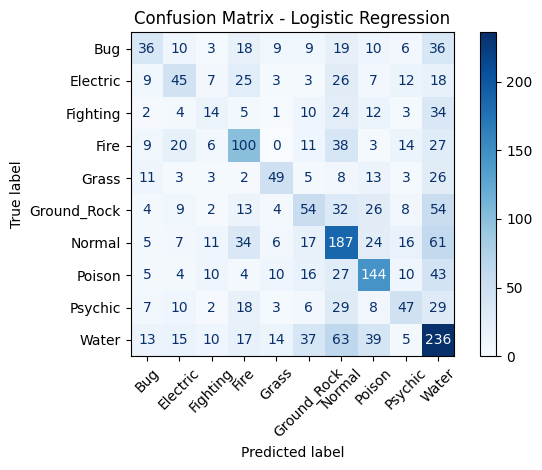

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test_lda,
    y_test,
    display_labels=label_mapping.keys(),  # or sorted(df['label'].unique())
    cmap='Blues',
    xticks_rotation=45
)

plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.tight_layout()
plt.show()


In [26]:
logreg.fit(X_train_lda, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'ovr'


In [28]:
print("Confusion matrix:\n", cm)
print("Report DataFrame:\n", report_df)


Confusion matrix:
 [[ 36  10   3  18   9   9  19  10   6  36]
 [  9  45   7  25   3   3  26   7  12  18]
 [  2   4  14   5   1  10  24  12   3  34]
 [  9  20   6 100   0  11  38   3  14  27]
 [ 11   3   3   2  49   5   8  13   3  26]
 [  4   9   2  13   4  54  32  26   8  54]
 [  5   7  11  34   6  17 187  24  16  61]
 [  5   4  10   4  10  16  27 144  10  43]
 [  7  10   2  18   3   6  29   8  47  29]
 [ 13  15  10  17  14  37  63  39   5 236]]
Report DataFrame:
                 Bug  Electric  Fighting      Fire     Grass  Ground_Rock  \
precision  0.356436  0.354331  0.205882  0.423729  0.494949     0.321429   
recall     0.230769  0.290323  0.128440  0.438596  0.398374     0.262136   
f1-score   0.280156  0.319149  0.158192  0.431034  0.441441     0.288770   

             Normal    Poison   Psychic     Water  
precision  0.412804  0.503497  0.379032  0.418440  
recall     0.508152  0.527473  0.295597  0.525612  
f1-score   0.455542  0.515206  0.332155  0.465943  


In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Define model
nb = GaussianNB()

# Hyperparameter grid for var_smoothing
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# Cross-validation scheme
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch with F1 macro as scoring (you can change)
grid_search = GridSearchCV(nb, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

# Fit on training LDA features
grid_search.fit(X_train_lda, y_train)

# Best model
best_nb = grid_search.best_estimator_

# Predict on test set
y_pred = best_nb.predict(X_test_lda)
y_proba = best_nb.predict_proba(X_test_lda) if hasattr(best_nb, 'predict_proba') else None

# Metrics
print("Best var_smoothing:", grid_search.best_params_['var_smoothing'])
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

if y_proba is not None and len(set(y_test)) == 2:  # binary ROC AUC
    print("ROC AUC:", roc_auc_score(y_test, y_proba[:, 1]))
elif y_proba is not None:  # multiclass ROC AUC
    print("ROC AUC (macro):", roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro'))
else:
    print("ROC AUC: Not available")

# Optionally print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best var_smoothing: 1e-09
Accuracy: 0.4137466307277628
Precision (macro): 0.3906082205466349
Recall (macro): 0.36920942779556454
F1-score (macro): 0.3765991703318997
ROC AUC (macro): 0.7886917184166166

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.26      0.31       156
           1       0.33      0.29      0.31       155
           2       0.21      0.14      0.17       109
           3       0.44      0.43      0.43       228
           4       0.49      0.41      0.44       123
           5       0.34      0.34      0.34       206
           6       0.41      0.51      0.46       368
           7       0.52      0.51      0.51       273
           8       0.35      0.31      0.33       159
           9       0.44      0.51      0.47       449

    accuracy                           0.41      2226
   macro avg       0.39      0.37      0.38      2226
weighted avg       0.41      0.41      0.41      2226



In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Define k-NN model
knn = KNeighborsClassifier()

# Hyperparameter grid to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Cross-validation scheme
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch with F1 macro scoring
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

# Fit on training LDA features
grid_search.fit(X_train_lda, y_train)

# Best model
best_knn = grid_search.best_estimator_

# Predict on test set
y_pred = best_knn.predict(X_test_lda)
y_proba = best_knn.predict_proba(X_test_lda) if hasattr(best_knn, 'predict_proba') else None

# Metrics
print("Best parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

if y_proba is not None and len(set(y_test)) == 2:  # binary ROC AUC
    print("ROC AUC:", roc_auc_score(y_test, y_proba[:, 1]))
elif y_proba is not None:  # multiclass ROC AUC
    print("ROC AUC (macro):", roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro'))
else:
    print("ROC AUC: Not available")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 0.4299191374663073
Precision (macro): 0.4072304404791337
Recall (macro): 0.3792697302597692
F1-score (macro): 0.3877590335030539
ROC AUC (macro): 0.739984576709021

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.24      0.31       156
           1       0.39      0.28      0.32       155
           2       0.20      0.16      0.18       109
           3       0.42      0.44      0.43       228
           4       0.53      0.41      0.46       123
           5       0.33      0.35      0.34       206
           6       0.43      0.53      0.48       368
           7       0.56      0.58      0.57       273
           8       0.33      0.28      0.30       159
           9       0.46      0.53      0.49       449

    accuracy                           0.43      2226
   macro avg       0.41      0.38      0.39      2226
weighted avg   

In [31]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Define SVM model
svm = SVC(probability=True)  # probability=True for predict_proba

# Hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # only used for 'rbf'
}

# Cross-validation scheme
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch with F1 macro scoring
grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

# Fit on training LDA features
grid_search.fit(X_train_lda, y_train)

# Best model
best_svm = grid_search.best_estimator_

# Predict on test set
y_pred = best_svm.predict(X_test_lda)
y_proba = best_svm.predict_proba(X_test_lda) if hasattr(best_svm, 'predict_proba') else None

# Metrics
print("Best parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

if y_proba is not None and len(set(y_test)) == 2:  # binary ROC AUC
    print("ROC AUC:", roc_auc_score(y_test, y_proba[:, 1]))
elif y_proba is not None:  # multiclass ROC AUC
    print("ROC AUC (macro):", roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro'))
else:
    print("ROC AUC: Not available")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.4281221922731357
Precision (macro): 0.4060724438156057
Recall (macro): 0.3829969899583772
F1-score (macro): 0.39074631976683183
ROC AUC (macro): 0.7754651194092883

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.25      0.30       156
           1       0.37      0.32      0.34       155
           2       0.27      0.17      0.21       109
           3       0.43      0.47      0.45       228
           4       0.51      0.41      0.45       123
           5       0.35      0.32      0.33       206
           6       0.45      0.50      0.47       368
           7       0.52      0.54      0.53       273
           8       0.35      0.31      0.33       159
           9       0.44      0.54      0.48       449

    accuracy                           0.43      2226
   macro avg       0.41      0.38      0.39      2226
weighted avg       0.42      0.43 

In [32]:
loaded_models = {
    "Logistic Regression": logreg,
    "Naive Bayes": best_nb,
    "k-NN": best_knn,
    "Support Vector Machine": best_svm
}


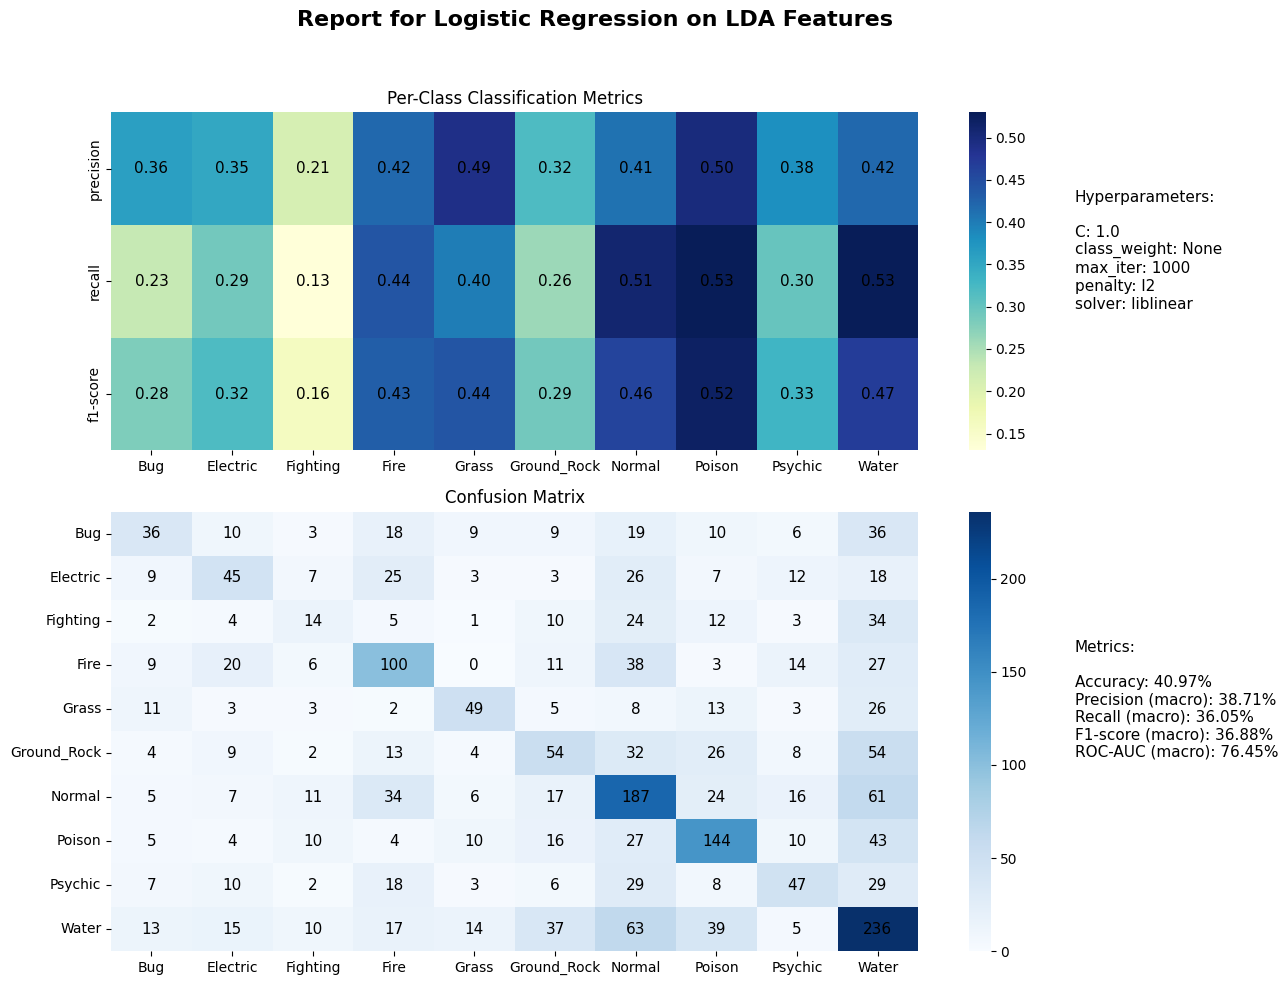

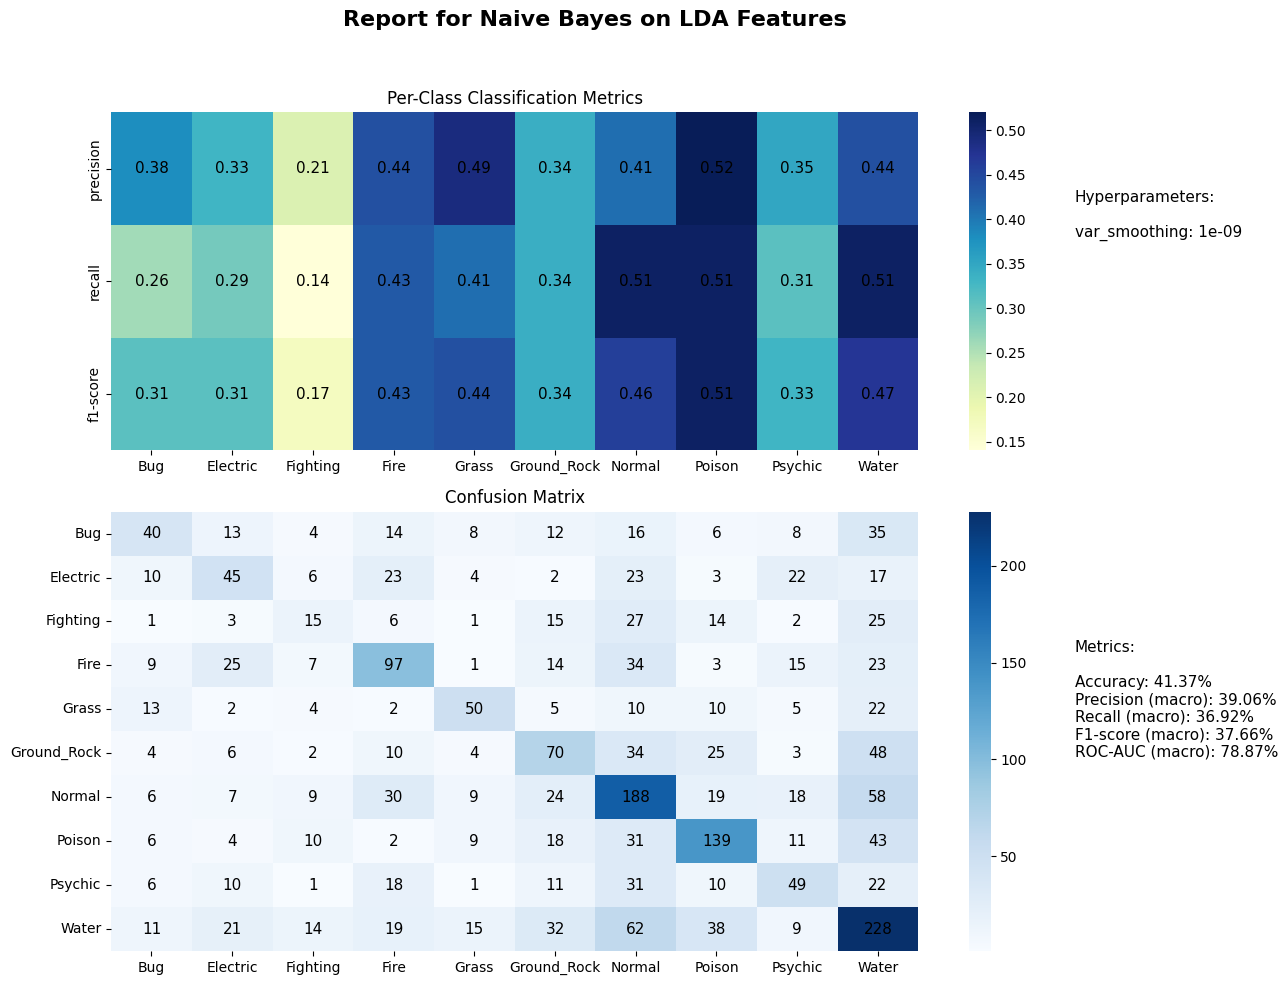

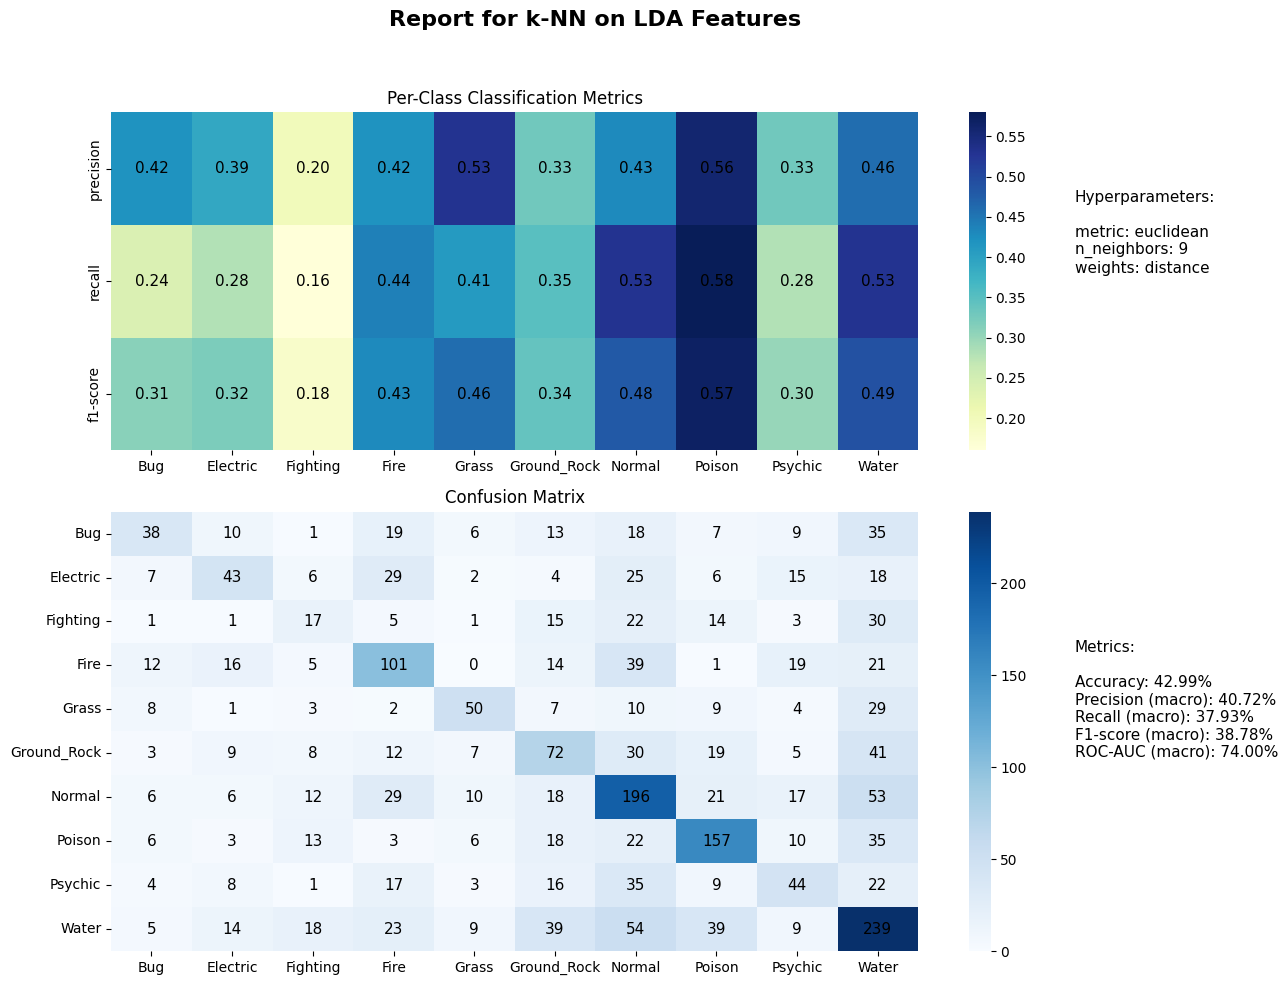

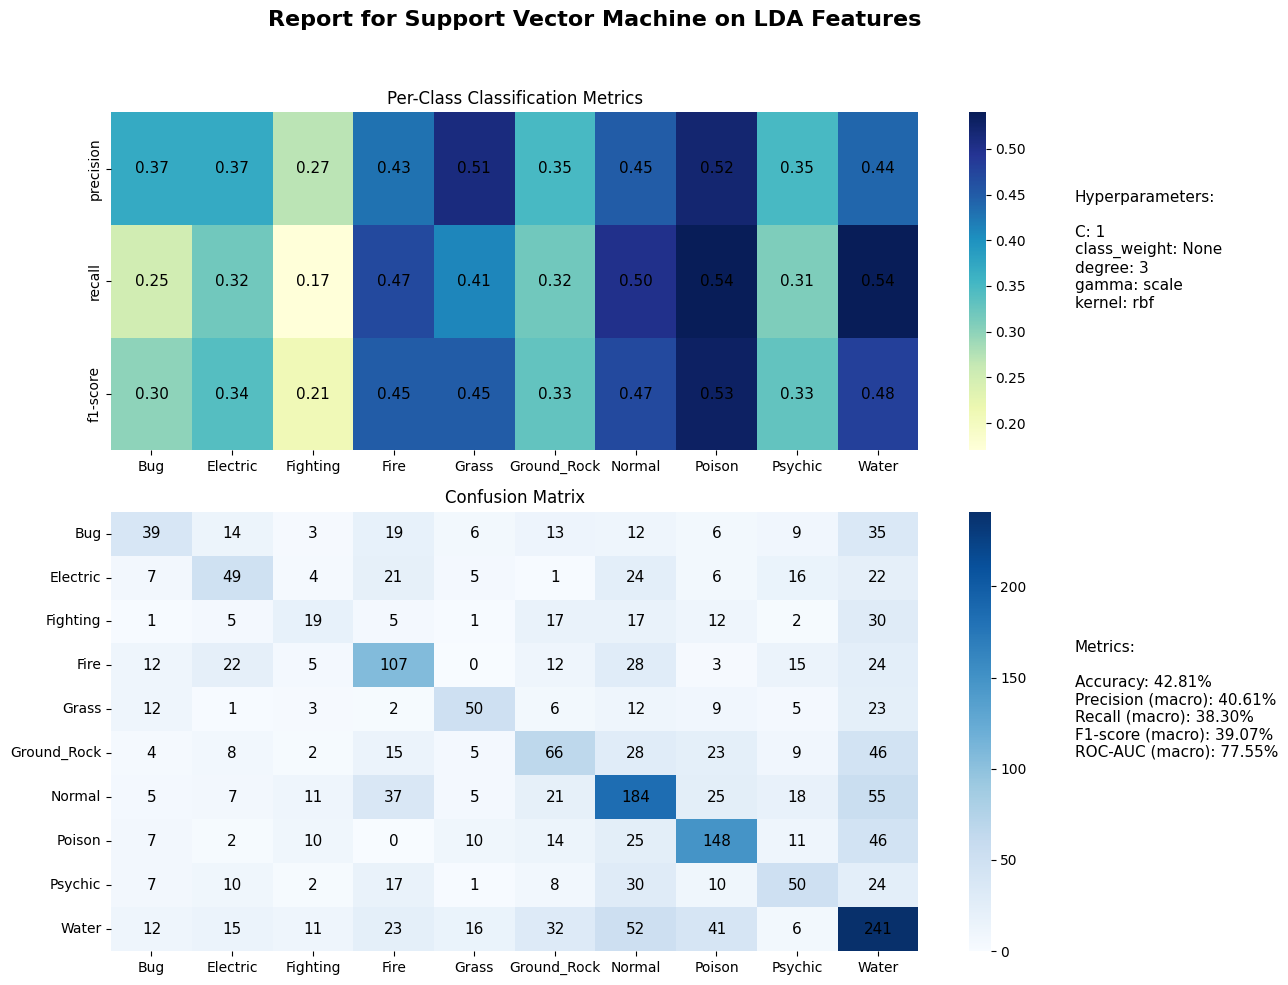

In [34]:
def get_filtered_params(model, keys_of_interest):
    return {k: v for k, v in model.get_params().items() if k in keys_of_interest}

# Main evaluation loop (for models trained on LDA features)
for name, model in loaded_models.items():
    # Define model-specific hyperparameter keys
    if "Logistic" in name:
        param_keys = ['penalty', 'C', 'solver', 'max_iter', 'class_weight']
    elif "Support Vector" in name:
        param_keys = ['kernel', 'C', 'gamma', 'degree', 'class_weight']
    elif "k-NN" in name:
        param_keys = ['n_neighbors', 'weights', 'metric']
    elif "Naive Bayes" in name:
        param_keys = ['var_smoothing']
    else:
        param_keys = []

    # Extract filtered hyperparameters
    if hasattr(model, "get_params"):
        filtered_params = get_filtered_params(model, param_keys)
    else:
        filtered_params = {}

    # Make predictions
    y_pred = model.predict(X_test_lda)
    try:
        y_proba = model.predict_proba(X_test_lda)
    except:
        y_proba = None

    # Classification report (dict format)
    report_dict = classification_report(
        y_test,
        y_pred,
        target_names=[k for k, v in sorted(label_mapping.items(), key=lambda x: x[1])],
        output_dict=True,
        zero_division=0
    )

    # Format the report
    report_dict = {
        k.title(): {kk: vv for kk, vv in v.items()}
        for k, v in report_dict.items() if isinstance(v, dict)
    }

    report_df = pd.DataFrame(report_dict).T
    report_df = report_df.drop(index=['Macro Avg', 'Weighted Avg'], errors='ignore')
    report_df = report_df.drop(columns=['support'], errors='ignore')
    report_df = report_df.round(2)
    report_df = report_df.T 


    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    metrics_text = (
        f"Accuracy: {acc*100:.2f}%\n"
        f"Precision (macro): {prec*100:.2f}%\n"
        f"Recall (macro): {rec*100:.2f}%\n"
        f"F1-score (macro): {f1*100:.2f}%"
    )

    if y_proba is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
            metrics_text += f"\nROC-AUC (macro): {roc_auc*100:.2f}%"
        except:
            metrics_text += "\nROC-AUC (macro): N/A"

    # Hyperparameters text
    param_text = "\n".join([f"{k}: {v}" for k, v in filtered_params.items()]) if filtered_params else "No hyperparameters available."

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1.3]})
    fig.suptitle(f"Report for {name} on LDA Features", fontsize=16, fontweight='bold')

    # Subplot 1: Classification report
    sns.heatmap(report_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, ax=ax1,
                annot_kws={"size": 11, "color": "black"})
    ax1.set_title("Per-Class Classification Metrics")

    # Hyperparameters text block
    fig.text(0.90, 0.80, f"Hyperparameters:\n\n{param_text}", fontsize=11, va='top', ha='left')

    # Subplot 2: Confusion matrix
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[k for k, v in sorted(label_mapping.items(), key=lambda x: x[1])],
        yticklabels=[k for k, v in sorted(label_mapping.items(), key=lambda x: x[1])],
        ax=ax2,
        annot_kws={"size": 11, "color": "black"}
    )
    ax2.set_title("Confusion Matrix")

    # Metrics text block
    fig.text(0.90, 0.35, f"Metrics:\n\n{metrics_text}", fontsize=11, va='top', ha='left')

    # Layout adjustment
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()
